# AI for science and government (ASG) community workshop
### 6, 7 July 2022 - Birmingham
#### Demonstration session

Lead by: Fernando Benitez-Paez -- Hadrien Salat

**Resources and useful links:**
- **SPC Repo:** https://github.com/alan-turing-institute/uatk-spc
- **SPC website:** https://alan-turing-institute.github.io/uatk-spc/
- **Urban Analytcs website:** https://www.turing.ac.uk/research/research-programmes/urban-analytics
- **Protocol buffers:**  https://developers.google.com/protocol-buffers/docs/overview


The following Notebook is a simple guide on how to use and explore the attributes/variables included in the .pb file created with the tool SPC.


### 1. From .pb to pandas dataframe
An initial exploration of the dimensions included in the output files is always a good start point to work with SyntPop. There is already a script to run in shell the following functionality in case you are not a Notebook person (https://github.com/alan-turing-institute/uatk-spc/blob/main/python/protobuf_to_csv.py)

In [1]:
import pandas as pd
import sys
import os
sys.path.append('../')
import synthpop_pb2

In [12]:
def convert_to_csv(input_path):
    """Export some per-person attributes to CSV."""
    # Parse the .pb file
    print(f"Reading {input_path}")
    pop = synthpop_pb2.Population()
    f = open(input_path, "rb")
    pop.ParseFromString(f.read())
    f.close()

    # Based on the per-person information you're interested in, you can extract
    # and fill out different columns
    people = []
    for person in pop.people:
        # The Person message doesn't directly store MSOA. Look up from their household.
        msoa11cd = pop.households[person.household].msoa11cd

        record = {
            "person_id": person.id,
            "household_id": person.household,
            "msoa11cd": msoa11cd,
            "age_years": person.demographics.age_years,
            # Protobuf enum types show up as numbers; this converts to a string
            "pwkstat": synthpop_pb2.PwkStat.Name(person.employment.pwkstat),
            "diabetes": person.health.has_diabetes,
            "employment": person.employment.sic1d07,
        }

        # Add a column for the duration the person spends doing each activity
        for pair in person.activity_durations:
            key = synthpop_pb2.Activity.Name(pair.activity) + "_duration"
            record[key] = pair.duration

        people.append(record)

    df = pd.DataFrame.from_records(people)
    return(df)

In [13]:
input_path = '../../data/output/rutland.pb'
if __name__ == "__main__":
    df = convert_to_csv(input_path)

Reading ../../data/output/rutland.pb


In [14]:
df

,person_id,household_id,msoa11cd,age_years,pwkstat,diabetes,employment,RETAIL_duration,PRIMARY_SCHOOL_duration,SECONDARY_SCHOOL_duration,HOME_duration,WORK_duration
0,0,0,E02002863,30,SELF_EMPLOYED,False,14,0.034722,0.000000,0.0,0.097222,0.166667
1,1,0,E02002863,1,NA,False,0,0.000000,0.256944,0.0,0.138889,0.000000
2,2,1,E02002863,30,EMPLOYEE_FT,False,16,0.000000,0.000000,0.0,0.069444,0.340278
3,3,1,E02002863,30,EMPLOYEE_FT,False,17,0.000000,0.000000,0.0,0.118056,0.340278
4,4,1,E02002863,10,NA,False,0,0.000000,0.270833,0.0,0.013889,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
39470,39470,16683,E02002867,78,RETIRED,False,16,0.069444,0.000000,0.0,0.020833,0.000000
39471,39471,16684,E02002867,61,RETIRED,False,16,0.000000,0.000000,0.0,1.000000,0.000000
39472,39472,16685,E02002867,25,EMPLOYEE_FT,False,13,0.000000,0.000000,0.0,0.173611,0.284722
39473,39473,16686,E02002867,42,EMPLOYEE_FT,False,15,0.000000,0.000000,0.0,0.048611,0.333333


### 2. Map the Venues

A second excersice a resercher migth do is to map the venues or individual and becase we have an spatially enriech sythn pop, we are also able to plot the synth venues ( randonmly located) and set of synth individuals created in the .pb file. There is already a script to run in shell the following functionality in case you are not a Notebook person (https://github.com/alan-turing-institute/uatk-spc/blob/main/python/protobuf_to_csv.py)

Reading ../../data/output/rutland.pb


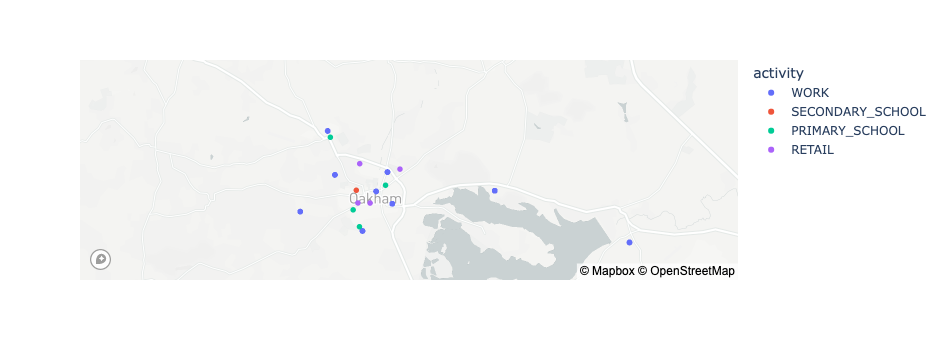

In [27]:
import plotly.express as px
import click

def draw_venues(input_path):
    """Draw a dot per venue, colored by activity."""
    print(f"Reading {input_path}")
    pop = synthpop_pb2.Population()
    f = open(input_path, "rb")
    pop.ParseFromString(f.read())
    f.close()

    dots = []
    for activity in pop.venues_per_activity.keys():
        for venue in pop.venues_per_activity[activity].venues:
            dots.append(
                (
                    venue.location.latitude,
                    venue.location.longitude,
                    synthpop_pb2.Activity.Name(activity),
                )
            )

    # This is some public Mapbox token, will eventually expire
    px.set_mapbox_access_token(
        "pk.eyJ1IjoibWFwYm94IiwiYSI6ImNpejY4NXVycTA2emYycXBndHRqcmZ3N3gifQ.rJcFIG214AriISLbB6B5aw"
    )
    df = pd.DataFrame(dots, columns=["latitude", "longitude", "activity"])
    fig = px.scatter_mapbox(df, lat="latitude", lon="longitude", color="activity")
    fig.show()

if __name__ == "__main__":
    draw_venues(input_path)